In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

from acquire import get_titanic_data

np.random.seed(123)


In [5]:
df = get_titanic_data()
df


,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,0,2,male,27.0,0,0,13.0000,S,Second,NaN,Southampton,1
887,887,1,1,female,19.0,0,0,30.0000,S,First,B,Southampton,1
888,888,0,3,female,NaN,1,2,23.4500,S,Third,NaN,Southampton,0
889,889,1,1,male,26.0,0,0,30.0000,C,First,C,Cherbourg,1


In [6]:
df.isna().sum()


passenger_id      0
survived          0
pclass            0
sex               0
age             177
sibsp             0
parch             0
fare              0
embarked          2
class             0
deck            688
embark_town       2
alone             0
dtype: int64

In [7]:
df.isna().mean()

passenger_id    0.000000
survived        0.000000
pclass          0.000000
sex             0.000000
age             0.198653
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.002245
class           0.000000
deck            0.772166
embark_town     0.002245
alone           0.000000
dtype: float64

In [8]:
# drop rows where age or embarked is null, drop column 'deck', drop passenger_id
def prep_titanic(df):
    '''
    take in titanc dataframe, remove all rows where age or embarked is null, 
    get dummy variables for sex and embark_town, 
    and drop sex, deck, passenger_id, class, and embark_town. 
    '''

    df = df[(df.age.notna()) & (df.embarked.notna())]
    df = df.drop(columns=['deck', 'passenger_id', 'class'])

    return df


In [9]:
df = prep_titanic(df)
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,embark_town,alone
0,0,3,male,22.0,1,0,7.2500,S,Southampton,0
1,1,1,female,38.0,1,0,71.2833,C,Cherbourg,0
2,1,3,female,26.0,0,0,7.9250,S,Southampton,1
3,1,1,female,35.0,1,0,53.1000,S,Southampton,0
4,0,3,male,35.0,0,0,8.0500,S,Southampton,1
...,...,...,...,...,...,...,...,...,...,...
885,0,3,female,39.0,0,5,29.1250,Q,Queenstown,0
886,0,2,male,27.0,0,0,13.0000,S,Southampton,1
887,1,1,female,19.0,0,0,30.0000,S,Southampton,1
889,1,1,male,26.0,0,0,30.0000,C,Cherbourg,1


In [10]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test


In [11]:
# Stratify with categorical target variables
train, validate, test = train_validate_test_split(df, target='survived')
train.shape, validate.shape, test.shape


((398, 10), (171, 10), (143, 10))

In [12]:
# Stratification means we'll get even proportions of the target variable in each data set
train.survived.mean(), validate.survived.mean(), test.survived.mean()


(0.4045226130653266, 0.40350877192982454, 0.40559440559440557)

# Questions to answer

## 1, pclass to survived. What's the relationship between survival and class of ticket?

$H_0$ : There is no  relationship betweeen survival and class of thicket?

$H_a$ : There is a relationship betweeen survival and class of thicket?

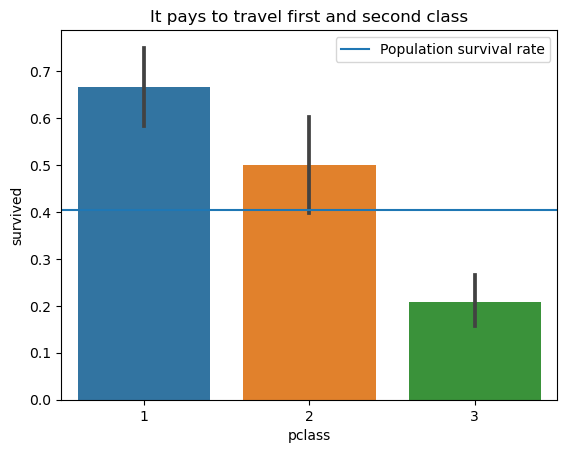

In [13]:
plt.title("It pays to travel first and second class")
sns.barplot(x="pclass", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()


In [11]:
observed = pd.crosstab(train.survived, train.pclass)
observed

pclass,1,2,3
survived,,,
0,36,49,152
1,72,49,40


In [12]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "survival and class of ticket are independent"
alternative_hypothesis = "there is a relationship between class of ticket and survival"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.pclass)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")
p


Reject the null hypothesis that survival and class of ticket are independent
Sufficient evidence to move forward understanding that there is a relationship between class of ticket and survival


6.956716773744683e-15

## 2. Is traveling with people more helpful for surviving?



$H_0$ : Traveling with people is equal to or less helpful for surviving.

$H_a$ : Traveling with people is more helpful for surviving.

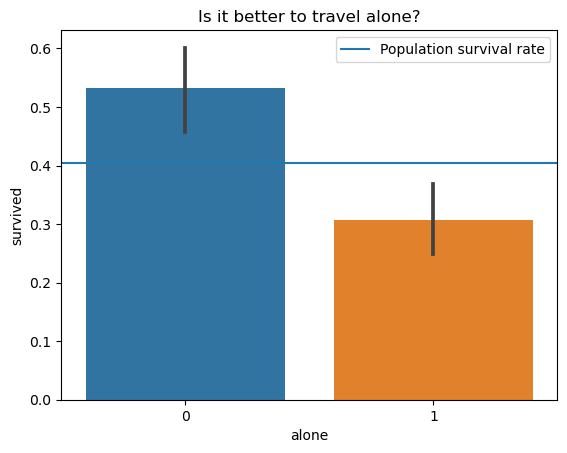

In [13]:
plt.title("Is it better to travel alone?")
sns.barplot(x="alone", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()


𝐻0  : Traveling with people is equal to or less helpful for surviving.
𝐻𝑎  : Traveling with people is more helpful for surviving.

In [14]:
observed = pd.crosstab(train.survived, train.alone)
observed

alone,0,1
survived,,
0,81,156
1,92,69


In [15]:
chi2, p, degf, expected = stats.chi2_contingency(observed)


In [16]:
chi2

19.653212321623755

In [17]:
p

9.284709086677199e-06

In [18]:
degf

1

In [19]:
expected

array([[103.01758794, 133.98241206],
       [ 69.98241206,  91.01758794]])

In [20]:
# If the visual was unclear or we need more confirmation, run a hypothesis test
# Let's run a chi squared to compare proportions
alpha = 0.05
null_hypothesis = "survival and traveling alone are independent"
alternative_hypothesis = "there is a relationship between survival and traveling alone"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.alone)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")


Reject the null hypothesis that survival and traveling alone are independent
Sufficient evidence to move forward understanding that there is a relationship between survival and traveling alone


## 3. What's the relationship between survival and gender?


$H_0$ : There is no relationship between survial and gender.

$H_a$ : There is a relationship between survial and gender.

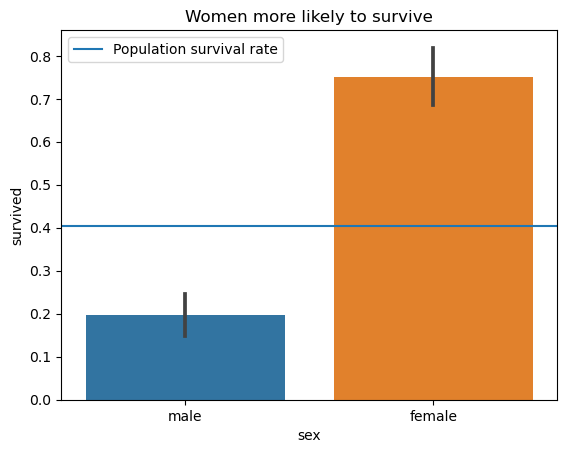

In [21]:
plt.title("Women more likely to survive")
sns.barplot(x="sex", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()


In [22]:
observed = pd.crosstab(train.survived, train.sex)
observed

sex,female,male
survived,,
0,37,200
1,112,49


In [23]:
chi2, p, degf, expected = stats.chi2_contingency(observed)


In [24]:
chi2

116.86177658329282

In [25]:
p

3.077878621816156e-27

In [26]:
degf

1

In [27]:
expected

array([[ 88.72613065, 148.27386935],
       [ 60.27386935, 100.72613065]])

In [28]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05

null_hypothesis = "survival and gender are independent"
alternative_hypothesis = "there is a relationship between survival and gender"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.sex)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")


Reject the null hypothesis that survival and gender are independent
Sufficient evidence to move forward understanding that there is a relationship between survival and gender


## 4. What's the relationship between fare and survival?

Comparing Numeric vs. a Categorical Example

If the visual is not completely clear, the need for a hypothesis test increases.

 - 1 First, set your confidence level and your alpha (Confidence level of 95% and alpha of 0.05 are good)
 - 2 Select the appropriate test for your 2 variables:
   - If numeric to numeric, run a correlation test
   - Compare proportions with χ^2
   - Compare means with t-test or Mann-Whitney u-test.
 - 3 Run tests, form conclusions, and document your results


$H_0$ : fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers


$H_a$ : fares paid by surviving passengers are higher than non-surviving passengers

In [29]:
This includes directionality, so one tailed. This is subgroup to subgroup so two sample. 
We are doing calegorical to continiuous, so we need a compare means test. 
check if fare is normally distributed.


SyntaxError: invalid syntax (673314443.py, line 1)

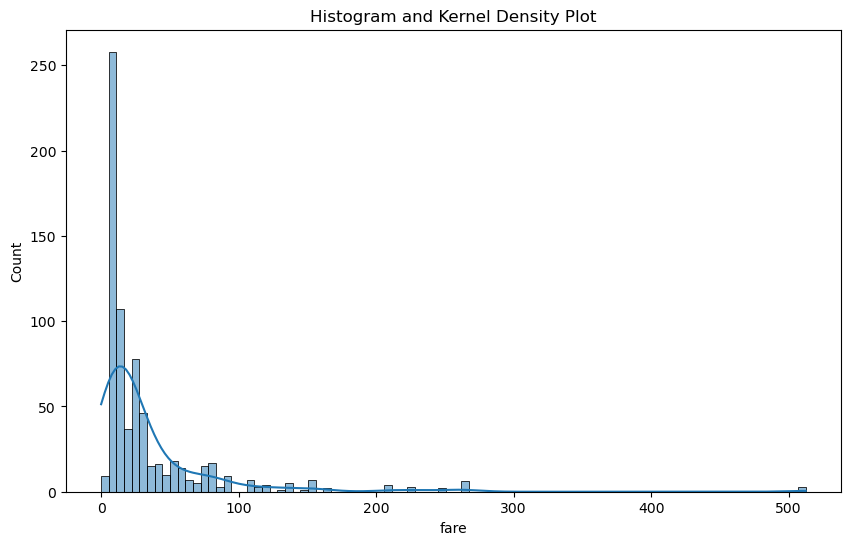

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df['fare'], kde=True)
plt.title('Histogram and Kernel Density Plot')
plt.show()

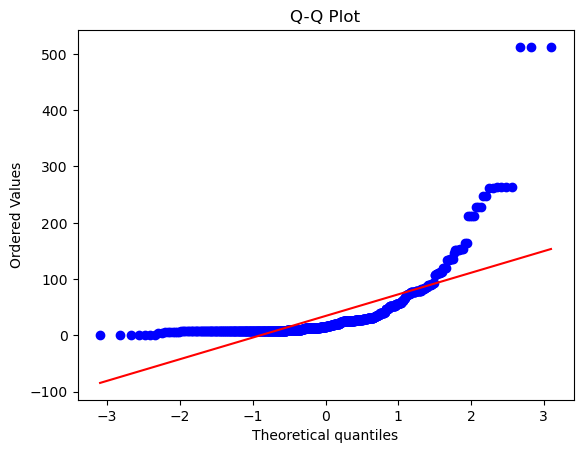

In [31]:
stats.probplot(df['fare'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [32]:
from scipy.stats import shapiro


In [33]:
# H0: the variable is normally distributed. 
# Ha: the varirable is not normally distributed.

In [ ]:
# Shapiro-Wilk test for normality
stat, p_value = shapiro(df['fare'])
print(f'Statistic: {stat}, p-value: {p_value}')

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print('The data does not appear to be normally distributed.')
else:
    print('The data appears to be normally distributed.')

In [37]:
    # low p value, we rejet the null hypotheisis and say the data are NOT normally distributed.
    # know now what stats test to use. Mann-Whitney.

In [38]:
# Using an f-string
p_value = f"{p_value:.5f}"

ValueError: Unknown format code 'f' for object of type 'str'

In [39]:
print("Formatted number using f-string:", p_value)

Formatted number using f-string: 0.00000


In [40]:
from scipy.stats import anderson

# Anderson-Darling test for normality
result = anderson(df['fare'])
print(f'Statistic: {result.statistic}, Critical Values: {result.critical_values}')

# Interpret the result
if result.statistic < result.critical_values[2]:
    print('The data appears to be normally distributed.')
else:
    print('The data does not appear to be normally distributed.')


Statistic: 96.78218835011535, Critical Values: [0.573 0.652 0.783 0.913 1.086]
The data does not appear to be normally distributed.


In [41]:
# Subset the data into survived and not-surviving status
not_survived = train[train.survived == 0]
survived = train[train.survived == 1]


In [42]:
not_survived

,survived,pclass,sex,age,sibsp,parch,fare,embarked,embark_town,alone
450,0,2,male,36.0,1,2,27.7500,S,Southampton,0
157,0,3,male,30.0,0,0,8.0500,S,Southampton,1
462,0,1,male,47.0,0,0,38.5000,S,Southampton,1
397,0,2,male,46.0,0,0,26.0000,S,Southampton,1
881,0,3,male,33.0,0,0,7.8958,S,Southampton,1
...,...,...,...,...,...,...,...,...,...,...
836,0,3,male,21.0,0,0,8.6625,S,Southampton,1
693,0,3,male,25.0,0,0,7.2250,C,Cherbourg,1
14,0,3,female,14.0,0,0,7.8542,S,Southampton,1
72,0,2,male,21.0,0,0,73.5000,S,Southampton,1


In [43]:
survived

,survived,pclass,sex,age,sibsp,parch,fare,embarked,embark_town,alone
543,1,2,male,32.0,1,0,26.0000,S,Southampton,0
3,1,1,female,35.0,1,0,53.1000,S,Southampton,0
853,1,1,female,16.0,0,1,39.4000,S,Southampton,0
710,1,1,female,24.0,0,0,49.5042,C,Cherbourg,1
706,1,2,female,45.0,0,0,13.5000,S,Southampton,1
...,...,...,...,...,...,...,...,...,...,...
750,1,2,female,4.0,1,1,23.0000,S,Southampton,0
821,1,3,male,27.0,0,0,8.6625,S,Southampton,1
820,1,1,female,52.0,1,1,93.5000,S,Southampton,0
673,1,2,male,31.0,0,0,13.0000,S,Southampton,1


In [44]:
# check variances of the two groups
not_survived.fare.var(), survived.fare.var()


(846.4473286218974, 7299.47475581913)

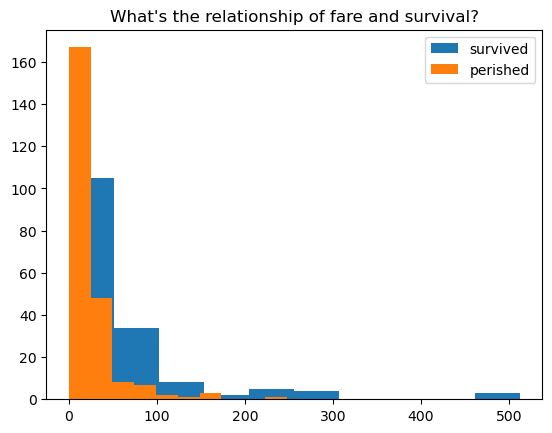

In [45]:
plt.title("What's the relationship of fare and survival?")
plt.hist(survived.fare, label="survived")
plt.hist(not_survived.fare, label="perished")
plt.legend()
plt.show()


In [46]:
from scipy import stats

null_hypothesis = "fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers"
alternative_hypothesis = "fares paid by surviving passengers are higher than non-surviving passengers"

# Use Mann Whitney u-test when t-test assumptions do not hold.
# The distributions are not normal and the variances are not equal, so we'll do mann-whitney
t, p = stats.mannwhitneyu(survived.fare, not_survived.fare, alternative="greater")


In [47]:
t

27468.5

In [48]:
p

4.665118844596931e-14

In [49]:
# there appears to be a relationship between whether someone survived or not and fare. 

In [51]:
# Passagers who sivived paid higher fare costs. 
